# EXPLORATORY DATA ANALYSIS
    # Merge sales and refunds based on ID
    # sales trends with respect to refund 
    # fish for patterns
    # handling dups and missing data
    # feature engineering
    # feature scaling
    # Creating target variable - IsRefund
 # MACHINE LEARNING SECTION
    # Build Clustering model
    # Evaluate the model
    # optional : study cost function
    # optional : feature engineering
    # optional : Regularize the model

It's worth noting that this analysis is based on real data but the dataset has been anonamyzed for PII and financial descretion purposes

In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
import os 
import datetime
warnings.filterwarnings("ignore")

In [92]:
# Opening csv file and assigning each sheet into a dataframe
path = '/Users/macbookpro/Downloads'
files = os.listdir(path)
for file in files: 
    if file.startswith("SALES AND REFUNDS"):
        sales = pd.read_excel(file, sheet_name='Sales')
        refunds = pd.read_excel(file, sheet_name='Refunds')

sales.shape, refunds.shape

((2184, 8), (3128, 15))

In [93]:
sales.head()

,Order Date,Id_user,Name,Language,Nb_Order,id_order,Sales parts,Sales total
0,2023-05-01,14901,A3,FR,1,75726926,160.8030,168.2952
1,2023-05-01,11062,A4,FR,1,75732791,147.8810,181.7594
2,2023-05-01,6717,A16,FR,2,75723131 / 75719543,352.7641,384.6729
3,2023-05-01,11860,A20,FR,1,75720380,113.8500,113.8500
4,2023-05-01,11074,A22,FR,1,75727160,7.5000,11.2420


In [94]:
max(sales["Order Date"])

Timestamp('2023-06-18 00:00:00')

In [95]:
refunds.head()

,refund date,id_user,Name,reason_category,reason_sub_category,reason,refund amount,mt_parts,mt_discount,mt_shipping,mt_services,id_order,Id,Order date,Sales total
0,2023-04-20,10774,A3,Refund after shipment,Customer mistake,Mounting,0.003334,11.170000,11.166666,0.00000,0.000000,74556836,74556836,2023-02-11,252.1412
1,2023-04-20,14901,A4,Cash credit note,Other,Other,74.919998,0.000000,0.000000,0.00000,74.919998,75228554,75228554,2023-03-28,74.9200
2,2023-04-20,14901,A4,Refund after shipment,Website wrong technical infos,Wrong infos,29.201670,34.160000,0.000000,-4.95833,0.000000,74956355,74956355,2023-03-08,39.5680
3,2023-04-20,11062,A6,Cancellation before shipment,Delay,Supplier,4.080000,4.080000,0.000000,0.00000,0.000000,75580370,75477617,2023-04-13,4.9200
4,2023-04-20,11062,A6,Refund after shipment,Garantee on deposit part,Garantee on deposit part,81.580002,81.580002,0.000000,0.00000,0.000000,73094854,73094854,2022-10-29,81.5800


In [96]:
min(refunds["refund date"]), min(refunds['Order date'])

(Timestamp('2023-01-03 00:00:00'), Timestamp('2018-02-06 00:00:00'))

In [97]:
max(refunds["refund date"]), max(refunds['Order date'])

(Timestamp('2023-06-18 00:00:00'), Timestamp('2023-06-17 00:00:00'))

In [98]:
min(sales["Order Date"]), max(sales["Order Date"])

(Timestamp('2022-12-01 00:00:00'), Timestamp('2023-06-18 00:00:00'))

Converting dates

In [99]:
sales['Order Date'] = pd.to_datetime(sales['Order Date'])

In [100]:
refunds['refund date'] = pd.to_datetime(refunds['refund date'])

In [101]:
refunds['Order date'] = pd.to_datetime(refunds['Order date'])

As you can see from the dates, the minimum date that our sales data extends to is 01/12 of 2022 so  it would be sensible to fillter out our refunds dataset to only keep data that goes back to that timestamp! because for any refunds related to sales that happened earlier to that date are not going to be traceablle from our sales data and hence it provides no siignificant information for our machine learning model.

In [130]:
# filtering out refunds to keep those confined within our available sales data
refunds = refunds[refunds['Order date'] >= min(sales["Order Date"])]

Obviously we need both dataframe for machine learning algorithm since we're trying to classifiy whether a sales is going to result in a refund or not! so first thing we need to merge the two Dataframe based of the Order ID

In [131]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2184 entries, 0 to 2183
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Order Date   2184 non-null   datetime64[ns]
 1   Id_user      2184 non-null   int64         
 2   Name         2184 non-null   object        
 3   Language     2184 non-null   object        
 4   Nb_Order     2184 non-null   int64         
 5   id_order     2184 non-null   object        
 6   Sales parts  2184 non-null   float64       
 7   Sales total  2184 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 136.6+ KB


upon inspection of sales head we noticed that some id's are not atomized, meaning there are two Id's mentioned in one cell, here's an example below: 

In [132]:
sales.iloc[2,5]

'75723131 / 75719543'

let's get a list of all the id that are composites

In [133]:
# checking how many ids contain '/' composites
sales[sales["id_order"].str.contains('/')]

,Order Date,Id_user,Name,Language,Nb_Order,id_order,Sales parts,Sales total
2,2023-05-01,6717,A16,FR,2,75723131 / 75719543,352.7641,384.6729
7,2023-05-02,14901,A3,FR,8,75736997 / 75740435 / 75745880 / 75739934 / 75...,591.4615,643.8112
8,2023-05-02,11062,A4,FR,8,75740162 / 75752702 / 75739307 / 75749261 / 75...,1280.6790,1493.5717
9,2023-05-02,15339,A5,FR,3,75741284 / 75739616 / 75737366,323.6275,355.8385
10,2023-05-02,15342,A8,FR,7,75737993 / 75748070 / 75739508 / 75742577 / 75...,756.9785,791.9286
...,...,...,...,...,...,...,...,...
2176,2022-12-31,10774,A2,FR,4,73919083 / 73920499 / 73922137 / 73921645,623.1602,644.3092
2180,2022-12-31,14841,A18,FR,3,73922431 / 73921498 / 73920580,638.6620,653.9790
2181,2022-12-31,11533,A27,FR,6,73921582 / 73921186 / 73922065 / 73923292 / 73...,485.0100,496.1600
2182,2022-12-31,11527,A28,FR,8,73920295 / 73920868 / 73919812 / 73924480 / 73...,1121.5409,1179.9807


let's see if there are any records from refunds that are expressed in the same way

In [134]:
refunds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2881 entries, 0 to 3127
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   refund date          2881 non-null   datetime64[ns]
 1   id_user              2881 non-null   int64         
 2   Name                 2881 non-null   object        
 3   reason_category      2881 non-null   object        
 4   reason_sub_category  2874 non-null   object        
 5   reason               2811 non-null   object        
 6   refund amount        2881 non-null   float64       
 7   mt_parts             2881 non-null   float64       
 8   mt_discount          2881 non-null   float64       
 9   mt_shipping          2881 non-null   float64       
 10  mt_services          2881 non-null   float64       
 11  id_order             2881 non-null   int64         
 12  Id                   2881 non-null   int64         
 13  Order date           2881 non-nul

as we can see here the id_order in refunds is of an integer type so it's not likely to contain "/" characters

since it's nearly impossible to know which of these parsed ids matches to which this data portion is gooing to irreleevant in our study, let's how much does it represent with respect tothe entire dataset

In [135]:
# deviding ids with '/' over total number of ids
composite_ids_percent = sales[sales["id_order"].str.contains('/')]["id_order"].count()/(sales["id_order"].count()) 
f'{composite_ids_percent:.2%}'

'83.65%'

84% is A LOT! after further inspection there is going to be no accurate way to connect these two data sources, information on sales is aggregated whilst in refunds it's given by sold items! for a 400 Eur total sales of id 1, 2 & 3 there's no way to know the price of each order unless they all appear in refunds.

Our approach is gonna consist of splitting the ids in sales and create duplicate rows for the same sale but with each id order,then after we merge the two datasets based on id, we'll nullify the ids where there's no match because the price there is going to be of the total amount

In [136]:
# let's create a list with the copy of our rows
new_rows = []
# iterating over our sales rows
for _, row in sales.iterrows():
    # creating list of resulting ids after spliting
    ids = row["id_order"].split('/')
    # creating a new row for each id in the list 
    for id in ids:
        # new row that is a copy of the old row with composite ids
        new_row = row.copy()
        # changing each id of the new row by a single id form ids list
        new_row['id_order'] = id
        # adding the row to the list of new rows
        new_rows.append(new_row)
# creating a new dataframe based of our new rows list
sales_ = pd.DataFrame(new_rows)
sales_

,Order Date,Id_user,Name,Language,Nb_Order,id_order,Sales parts,Sales total
0,2023-05-01,14901,A3,FR,1,75726926,160.8030,168.2952
1,2023-05-01,11062,A4,FR,1,75732791,147.8810,181.7594
2,2023-05-01,6717,A16,FR,2,75723131,352.7641,384.6729
2,2023-05-01,6717,A16,FR,2,75719543,352.7641,384.6729
3,2023-05-01,11860,A20,FR,1,75720380,113.8500,113.8500
...,...,...,...,...,...,...,...,...
2182,2022-12-31,11527,A28,FR,8,73920079,1121.5409,1179.9807
2182,2022-12-31,11527,A28,FR,8,73921903,1121.5409,1179.9807
2182,2022-12-31,11527,A28,FR,8,73920415,1121.5409,1179.9807
2183,2022-12-31,11443,A29,FR,2,73919659,108.9000,120.5499


In [137]:
# Let's drop the old index
sales_.reset_index(drop=True, inplace=True)

In [138]:
# before merging let's make sure both key columns have the same dtype
sales_['id_order']= sales_['id_order'].astype('int64')

In [139]:
sales_['id_order'].dtype, refunds['id_order'].dtype

(dtype('int64'), dtype('int64'))

In [170]:
# merging the two dataframes based of IDs
merged = pd.merge(sales_, refunds, how='left', on='id_order')

In [171]:
merged.head(10)

,Order Date,Id_user,Name_x,Language,Nb_Order,id_order,Sales parts,Sales total_x,refund date,id_user,...,reason_sub_category,reason,refund amount,mt_parts,mt_discount,mt_shipping,mt_services,Id,Order date,Sales total_y
0,2023-05-01,14901,A3,FR,1,75726926,160.8030,168.2952,2023-05-10,14901.0,...,Out of stock,Partial,9.675000,10.750000,1.075000,0.0,0.0,75726926.0,2023-05-01,204.0292
1,2023-05-01,14901,A3,FR,1,75726926,160.8030,168.2952,2023-05-22,14901.0,...,Received improper part,Missing products,61.353000,68.170000,6.817000,0.0,0.0,75726926.0,2023-05-01,204.0292
2,2023-05-01,11062,A4,FR,1,75732791,147.8810,181.7594,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3,2023-05-01,6717,A16,FR,2,75723131,352.7641,384.6729,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
4,2023-05-01,6717,A16,FR,2,75719543,352.7641,384.6729,2023-06-07,6717.0,...,Website wrong technical infos,Missing infos,21.104868,28.139824,7.034956,0.0,0.0,75719543.0,2023-05-01,401.2315
5,2023-05-01,6717,A16,FR,2,75719543,352.7641,384.6729,2023-06-07,6717.0,...,Website wrong technical infos,Wrong infos,60.584654,80.779539,20.194885,0.0,0.0,75719543.0,2023-05-01,401.2315
6,2023-05-01,11860,A20,FR,1,75720380,113.8500,113.8500,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
7,2023-05-01,11074,A22,FR,1,75727160,7.5000,11.2420,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
8,2023-05-01,11527,A28,FR,1,75727505,114.5510,123.6261,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
9,2023-05-01,11443,A29,FR,1,75725252,70.0800,99.1600,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN


In [172]:
list(merged.columns)

['Order Date',
 'Id_user',
 'Name_x',
 'Language',
 'Nb_Order',
 'id_order',
 'Sales parts',
 'Sales total_x',
 'refund date',
 'id_user',
 'Name_y',
 'reason_category',
 'reason_sub_category',
 'reason',
 'refund amount',
 'mt_parts',
 'mt_discount',
 'mt_shipping',
 'mt_services',
 'Id',
 'Order date',
 'Sales total_y']

In [181]:
# getting rid of duplicated columns and extract only those useful
df = merged[['Order Date','refund date','Id_user', 'Name_x', 'Language','id_order','Id',
             'Nb_Order','reason_sub_category','reason',
             'Sales parts','Sales total_x','Sales total_y',
             'refund amount','mt_parts', 'mt_discount']]
df

,Order Date,refund date,Id_user,Name_x,Language,id_order,Id,Nb_Order,reason_sub_category,reason,Sales parts,Sales total_x,Sales total_y,refund amount,mt_parts,mt_discount
0,2023-05-01,2023-05-10,14901,A3,FR,75726926,75726926.0,1,Out of stock,Partial,160.8030,168.2952,204.0292,9.675000,10.750000,1.075000
1,2023-05-01,2023-05-22,14901,A3,FR,75726926,75726926.0,1,Received improper part,Missing products,160.8030,168.2952,204.0292,61.353000,68.170000,6.817000
2,2023-05-01,NaT,11062,A4,FR,75732791,NaN,1,NaN,NaN,147.8810,181.7594,NaN,NaN,NaN,NaN
3,2023-05-01,NaT,6717,A16,FR,75723131,NaN,2,NaN,NaN,352.7641,384.6729,NaN,NaN,NaN,NaN
4,2023-05-01,2023-06-07,6717,A16,FR,75719543,75719543.0,2,Website wrong technical infos,Missing infos,352.7641,384.6729,401.2315,21.104868,28.139824,7.034956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10876,2022-12-31,NaT,11527,A28,FR,73920079,NaN,8,NaN,NaN,1121.5409,1179.9807,NaN,NaN,NaN,NaN
10877,2022-12-31,NaT,11527,A28,FR,73921903,NaN,8,NaN,NaN,1121.5409,1179.9807,NaN,NaN,NaN,NaN
10878,2022-12-31,NaT,11527,A28,FR,73920415,NaN,8,NaN,NaN,1121.5409,1179.9807,NaN,NaN,NaN,NaN
10879,2022-12-31,NaT,11443,A29,FR,73919659,NaN,2,NaN,NaN,108.9000,120.5499,NaN,NaN,NaN,NaN


In [182]:
# replacing empty ids with 0
df['Id'].fillna(0, inplace=True)

In [183]:
# creating target column classifying whether a sale result in a refund or not
df['Is_Refund'] = np.where(df['Id'] == 0, 0, 1)

In [184]:
df

,Order Date,refund date,Id_user,Name_x,Language,id_order,Id,Nb_Order,reason_sub_category,reason,Sales parts,Sales total_x,Sales total_y,refund amount,mt_parts,mt_discount,Is_Refund
0,2023-05-01,2023-05-10,14901,A3,FR,75726926,75726926.0,1,Out of stock,Partial,160.8030,168.2952,204.0292,9.675000,10.750000,1.075000,1
1,2023-05-01,2023-05-22,14901,A3,FR,75726926,75726926.0,1,Received improper part,Missing products,160.8030,168.2952,204.0292,61.353000,68.170000,6.817000,1
2,2023-05-01,NaT,11062,A4,FR,75732791,0.0,1,NaN,NaN,147.8810,181.7594,NaN,NaN,NaN,NaN,0
3,2023-05-01,NaT,6717,A16,FR,75723131,0.0,2,NaN,NaN,352.7641,384.6729,NaN,NaN,NaN,NaN,0
4,2023-05-01,2023-06-07,6717,A16,FR,75719543,75719543.0,2,Website wrong technical infos,Missing infos,352.7641,384.6729,401.2315,21.104868,28.139824,7.034956,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10876,2022-12-31,NaT,11527,A28,FR,73920079,0.0,8,NaN,NaN,1121.5409,1179.9807,NaN,NaN,NaN,NaN,0
10877,2022-12-31,NaT,11527,A28,FR,73921903,0.0,8,NaN,NaN,1121.5409,1179.9807,NaN,NaN,NaN,NaN,0
10878,2022-12-31,NaT,11527,A28,FR,73920415,0.0,8,NaN,NaN,1121.5409,1179.9807,NaN,NaN,NaN,NaN,0
10879,2022-12-31,NaT,11443,A29,FR,73919659,0.0,2,NaN,NaN,108.9000,120.5499,NaN,NaN,NaN,NaN,0


The intuition here is to predict whether a sale is gonna eventually turn into a refund or not. so for that we need to choose select features from cells, which also might mean that we'll need to engineer some new features like the day difference betweeen ordeer date and refund date indicating that the more days go by the more likely a sale is going to. generate a refund, we'll explore this in detail using EDA

In [187]:
# filling NA with appropriate data
df[['reason','reason_sub_category']] = df[['reason','reason_sub_category']].fillna('Not refund')
df[['Sales total_y','refund amount','mt_parts','mt_discount']] = df[['Sales total_y','refund amount','mt_parts','mt_discount']].fillna(0)


In [195]:
# let's get the day difference between a sale and a refund
df['Day difference'] = np.where(df['refund date'] != None,
                                (df['refund date']-df['Order Date']).dt.days,
                                None) 

In [193]:
# calculating the day of week number
df['day of week'] = df['Order Date'].dt.weekday

In [194]:
# getting the month number from sale date
df['month'] = df['Order Date'].dt.month

In [232]:
df.head(3)

,Order Date,refund date,Id_user,Name_x,Language,id_order,Id,Nb_Order,reason_sub_category,reason,Sales parts,Sales total_x,Sales total_y,refund amount,mt_parts,mt_discount,Is_Refund,Day difference,day of week,month
0,2023-05-01,2023-05-10,14901,A3,FR,75726926,75726926.0,1,Out of stock,Partial,160.803,168.2952,204.0292,9.675,10.75,1.075,1,9.0,0,5
1,2023-05-01,2023-05-22,14901,A3,FR,75726926,75726926.0,1,Received improper part,Missing products,160.803,168.2952,204.0292,61.353,68.17,6.817,1,21.0,0,5
2,2023-05-01,NaT,11062,A4,FR,75732791,0.0,1,Not refund,Not refund,147.881,181.7594,0.0000,0.000,0.00,0.000,0,NaN,0,5


In [229]:
import cufflinks as cf
cf.go_offline(True)

In [249]:
pie_refund=df[['Is_Refund','id_order']].groupby('Is_Refund').count().rename(columns={'id_order':'Count'}).reset_index()

In [250]:
pie_refund['Is_Refund'] =pie_refund["Is_Refund"].map({0:'No refund', 1:'Refund'})

In [251]:
pie_refund

,Is_Refund,Count
0,No refund,8552
1,Refund,2329


In [258]:
pie_refund.iplot(kind='pie',labels='Is_Refund',hole=.6,values='Count')

In [297]:
agent_refund= df[df['Is_Refund'] == 1][['Name_x',
                                        'id_order']].groupby(['Name_x']).count().rename(columns={'id_order'
                                                                                         :'Count'}).reset_index()


In [303]:
agent_refund.sort_values('Count',axis=0, ascending=False).iplot(kind='bar',
                                                                x='Name_x',
                                                                y='Count',
                                                                sortbars=True,
                                                               title='Refunds by agents')

In [306]:
df.iplot(kind='bar', x='day of week',y='Is_Refund', title='Refund per weekday (Monday to Sunday)')

In [309]:
df["avg sale"] = df['Sales parts'] / df['Nb_Order']

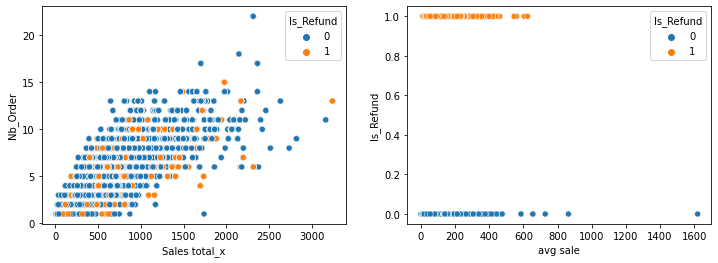

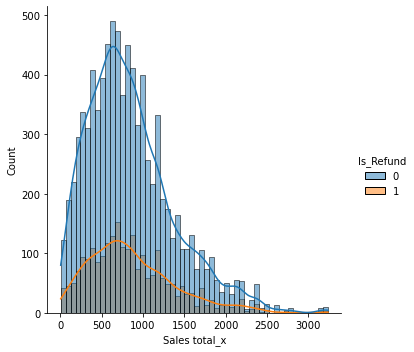

In [311]:
fig, axes = plt.subplots(1, 2,figsize=(12, 4))

# scatter plot between sales and number of parts sold
sns.scatterplot(data=df, x='Sales total_x',y='Nb_Order', hue='Is_Refund', ax=axes[0])

# scatter plot between sales and number of parts sold
sns.scatterplot(data=df, x='avg sale',y='Is_Refund', hue='Is_Refund', ax=axes[1])

# distribution of amounts
sns.displot(x=df['Sales total_x'], color='orange', hue=df['Is_Refund'], kde=True)


In [314]:
df.head(1)

,Order Date,refund date,Id_user,Name_x,Language,id_order,Id,Nb_Order,reason_sub_category,reason,...,Sales total_x,Sales total_y,refund amount,mt_parts,mt_discount,Is_Refund,Day difference,day of week,month,avg sale
0,2023-05-01,2023-05-10,14901,A3,FR,75726926,75726926.0,1,Out of stock,Partial,...,168.2952,204.0292,9.675,10.75,1.075,1,9.0,0,5,160.803


In [402]:
# Creating a subset of our dataframe to be the machine learning model input 
model_input = df[['Name_x','Nb_Order','avg sale','day of week','Is_Refund']]

In [403]:
# Creating dummies for Name column
dummies = pd.get_dummies(model_input['Name_x'], drop_first=True)

In [404]:
# here we're concatenating our original dataframe and the dummies we created
to_model = pd.concat([model_input, dummies], axis=1) 

In [405]:
# let's drop the original name column that contains str values
to_model.drop(['Nb_Order','Name_x'], axis=1, inplace=True)
to_model.head(1)

,avg sale,day of week,Is_Refund,A10,A11,A12,A13,A14,A15,A16,...,A29,A3,A30,A31,A4,A5,A6,A7,A8,A9
0,160.803,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [406]:
# let's use a min max scaler to scale the features sincee we have a discrepency in terms of scales
from sklearn.preprocessing import MinMaxScaler

In [407]:
Scaler = MinMaxScaler()

In [408]:
# Creating the input Matrix for our model
X = Scaler.fit_transform(to_model.drop('Is_Refund', axis=1))

In [409]:
from sklearn.model_selection import train_test_split

In [410]:
# Creating our target variables that's going to be the subject of our prediction
y = to_model['Is_Refund'].values

In [411]:
X.shape, y.shape

((10881, 32), (10881,))

In [412]:
#splitting data into train and test with 33% as test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [413]:
# using K nearest nighbors model to perform a two category classification
from sklearn.neighbors import KNeighborsClassifier

In [414]:
KNN = KNeighborsClassifier()

In [415]:
KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [416]:
preds = KNN.predict(X_test)

In [417]:
from sklearn.metrics import classification_report, confusion_matrix

In [419]:
print(confusion_matrix(y_test, preds))
print('**'*30)
print(classification_report(y_test, preds))
print(('**'*30))

[[2636  210]
 [ 643  102]]
************************************************************
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      2846
           1       0.33      0.14      0.19       745

    accuracy                           0.76      3591
   macro avg       0.57      0.53      0.53      3591
weighted avg       0.70      0.76      0.72      3591

************************************************************


In [377]:
from sklearn.model_selection import GridSearchCV

In [420]:
KNN.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [421]:
params={'n_neighbors':list(range(5, 25)),
        'metric':['euclidean','minkowski','manhattan'],
       'weights':['uniform','distance']}

In [422]:
grid = GridSearchCV(KNN, param_grid=params, verbose=3)

In [423]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.753 total time=   0.2s
[CV 2/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.756 total time=   0.2s
[CV 3/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.748 total time=   0.2s
[CV 4/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.739 total time=   0.2s
[CV 5/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.763 total time=   0.2s
[CV 1/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.737 total time=   0.1s
[CV 2/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.742 total time=   0.1s
[CV 3/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.733 total time=   0.1s
[CV 4/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.730 total time=   0.1s
[CV 5/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.761 t

[CV 2/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.750 total time=   0.1s
[CV 3/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.743 total time=   0.1s
[CV 4/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.739 total time=   0.1s
[CV 5/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.763 total time=   0.1s
[CV 1/5] END metric=euclidean, n_neighbors=14, weights=uniform;, score=0.784 total time=   0.2s
[CV 2/5] END metric=euclidean, n_neighbors=14, weights=uniform;, score=0.778 total time=   0.2s
[CV 3/5] END metric=euclidean, n_neighbors=14, weights=uniform;, score=0.778 total time=   0.2s
[CV 4/5] END metric=euclidean, n_neighbors=14, weights=uniform;, score=0.778 total time=   0.2s
[CV 5/5] END metric=euclidean, n_neighbors=14, weights=uniform;, score=0.778 total time=   0.2s
[CV 1/5] END metric=euclidean, n_neighbors=14, weights=distance;, score=0.739 total time=   0.1s
[CV 2/5] END metric=euclidean, n_ne

[CV 3/5] END metric=euclidean, n_neighbors=22, weights=uniform;, score=0.781 total time=   0.2s
[CV 4/5] END metric=euclidean, n_neighbors=22, weights=uniform;, score=0.778 total time=   0.2s
[CV 5/5] END metric=euclidean, n_neighbors=22, weights=uniform;, score=0.782 total time=   0.2s
[CV 1/5] END metric=euclidean, n_neighbors=22, weights=distance;, score=0.740 total time=   0.2s
[CV 2/5] END metric=euclidean, n_neighbors=22, weights=distance;, score=0.750 total time=   0.2s
[CV 3/5] END metric=euclidean, n_neighbors=22, weights=distance;, score=0.745 total time=   0.2s
[CV 4/5] END metric=euclidean, n_neighbors=22, weights=distance;, score=0.738 total time=   0.1s
[CV 5/5] END metric=euclidean, n_neighbors=22, weights=distance;, score=0.762 total time=   0.1s
[CV 1/5] END metric=euclidean, n_neighbors=23, weights=uniform;, score=0.783 total time=   0.2s
[CV 2/5] END metric=euclidean, n_neighbors=23, weights=uniform;, score=0.781 total time=   0.2s
[CV 3/5] END metric=euclidean, n_ne

[CV 4/5] END metric=minkowski, n_neighbors=10, weights=distance;, score=0.740 total time=   0.1s
[CV 5/5] END metric=minkowski, n_neighbors=10, weights=distance;, score=0.762 total time=   0.1s
[CV 1/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.778 total time=   0.2s
[CV 2/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.772 total time=   0.2s
[CV 3/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.772 total time=   0.2s
[CV 4/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.767 total time=   0.2s
[CV 5/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.761 total time=   0.2s
[CV 1/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.737 total time=   0.1s
[CV 2/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.751 total time=   0.1s
[CV 3/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.743 total time=   0.1s
[CV 4/5] END metric=minkowski, n_ne

[CV 5/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.778 total time=   0.2s
[CV 1/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.739 total time=   0.1s
[CV 2/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.750 total time=   0.1s
[CV 3/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.743 total time=   0.1s
[CV 4/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.739 total time=   0.1s
[CV 5/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.762 total time=   0.1s
[CV 1/5] END metric=minkowski, n_neighbors=20, weights=uniform;, score=0.784 total time=   0.2s
[CV 2/5] END metric=minkowski, n_neighbors=20, weights=uniform;, score=0.781 total time=   0.2s
[CV 3/5] END metric=minkowski, n_neighbors=20, weights=uniform;, score=0.781 total time=   0.2s
[CV 4/5] END metric=minkowski, n_neighbors=20, weights=uniform;, score=0.779 total time=   0.2s
[CV 5/5] END metric=minkowski, n_ne

[CV 1/5] END metric=manhattan, n_neighbors=8, weights=uniform;, score=0.778 total time=   0.3s
[CV 2/5] END metric=manhattan, n_neighbors=8, weights=uniform;, score=0.785 total time=   0.3s
[CV 3/5] END metric=manhattan, n_neighbors=8, weights=uniform;, score=0.772 total time=   0.3s
[CV 4/5] END metric=manhattan, n_neighbors=8, weights=uniform;, score=0.767 total time=   0.3s
[CV 5/5] END metric=manhattan, n_neighbors=8, weights=uniform;, score=0.773 total time=   0.3s
[CV 1/5] END metric=manhattan, n_neighbors=8, weights=distance;, score=0.738 total time=   0.3s
[CV 2/5] END metric=manhattan, n_neighbors=8, weights=distance;, score=0.750 total time=   0.3s
[CV 3/5] END metric=manhattan, n_neighbors=8, weights=distance;, score=0.743 total time=   0.3s
[CV 4/5] END metric=manhattan, n_neighbors=8, weights=distance;, score=0.738 total time=   0.3s
[CV 5/5] END metric=manhattan, n_neighbors=8, weights=distance;, score=0.762 total time=   0.3s
[CV 1/5] END metric=manhattan, n_neighbors=9,

[CV 2/5] END metric=manhattan, n_neighbors=16, weights=distance;, score=0.750 total time=   0.3s
[CV 3/5] END metric=manhattan, n_neighbors=16, weights=distance;, score=0.743 total time=   0.3s
[CV 4/5] END metric=manhattan, n_neighbors=16, weights=distance;, score=0.739 total time=   0.3s
[CV 5/5] END metric=manhattan, n_neighbors=16, weights=distance;, score=0.763 total time=   0.3s
[CV 1/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.779 total time=   0.3s
[CV 2/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.780 total time=   0.3s
[CV 3/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.776 total time=   0.3s
[CV 4/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.776 total time=   0.3s
[CV 5/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.778 total time=   0.3s
[CV 1/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.739 total time=   0.3s
[CV 2/5] END metric=manhattan, n_ne

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'minkowski', 'manhattan'],
                         'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                         16, 17, 18, 19, 20, 21, 22, 23, 24],
                         'weights': ['uniform', 'distance']},
             verbose=3)

In [425]:
grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 24, 'weights': 'uniform'}

In [426]:
grid_pred = grid.predict(X_test)

In [427]:
print(confusion_matrix(y_test, grid_pred))
print('**'*30)
print(classification_report(y_test, grid_pred))
print(('**'*30))

[[2828   18]
 [ 735   10]]
************************************************************
              precision    recall  f1-score   support

           0       0.79      0.99      0.88      2846
           1       0.36      0.01      0.03       745

    accuracy                           0.79      3591
   macro avg       0.58      0.50      0.45      3591
weighted avg       0.70      0.79      0.70      3591

************************************************************
